In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import os
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.naive_bayes import MultinomialNB

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rmisra/news-category-dataset
!unzip /content/news-category-dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 90% 24.0M/26.5M [00:01<00:00, 27.0MB/s]
100% 26.5M/26.5M [00:01<00:00, 16.7MB/s]
Archive:  /content/news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


In [ ]:
import json
dataset=[]
with open('News_Category_Dataset_v3.json', 'r') as f:
    for line in f:
        content = json.loads(line)
        dataset.append(content)
dataset = pd.DataFrame(data=dataset)
dataset.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
print(dataset.columns)


Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')


In [ ]:
#Get count for each category
category_count = dataset['category'].value_counts()
print(category_count)
print(f'There are {len(category_count)} categories of news')

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

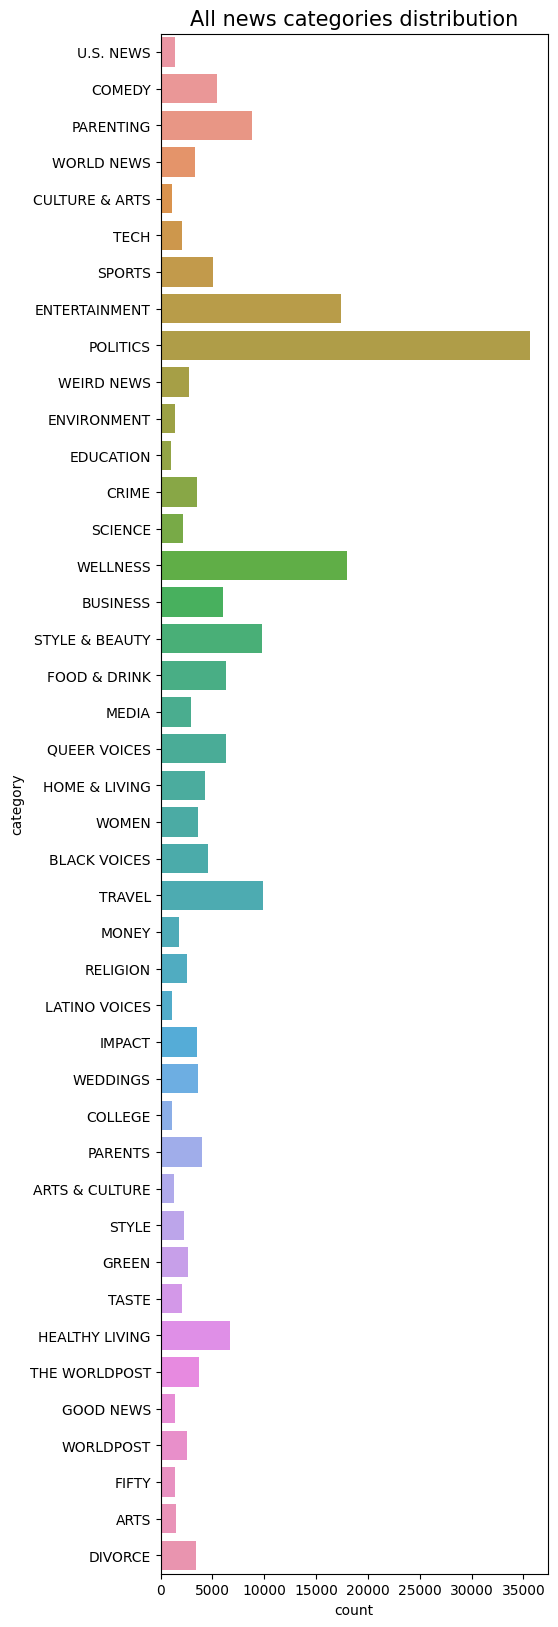

In [ ]:
#Plot horizontal category distribution
plt.figure(figsize = [5, 20])
sns.countplot(y=dataset["category"], orient = 'h')
plt.title("All news categories distribution", fontsize = 15)
plt.show()

**From the results above, there are in total of 42 categories of news. To accomodate with computing power, we will train models with the top 15 categories** **bold text**

['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS']


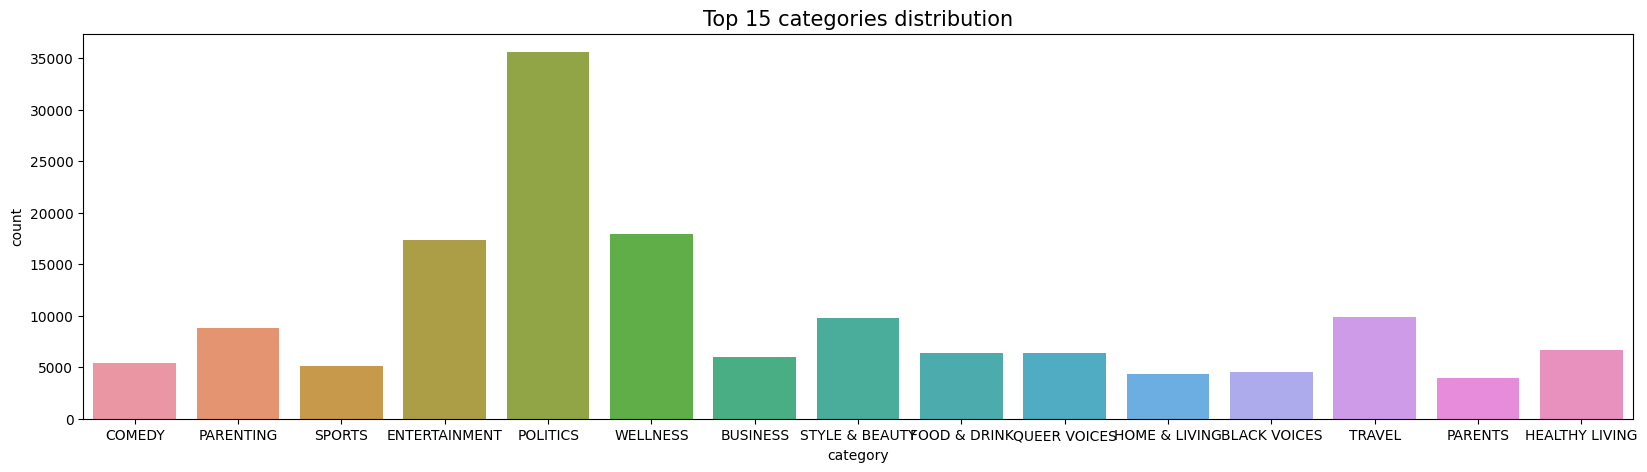

In [ ]:
# only top 15 train data counts
top_categories = list(dataset["category"].value_counts().nlargest(15).keys())
print(top_categories)

dataset_top = dataset[dataset['category'].isin(top_categories)]
plt.figure(figsize = [20, 5])
sns.countplot(x=dataset_top["category"])
plt.title("Top 15 categories distribution", fontsize = 15)
plt.show()

**There are around 35000 news in "POLITICS" group, which is the largest group. But most of the groups contain less than 7000 news. In order to solve imbalanced dataset issue, we use upsample technique.**

In [ ]:
# Upsampling the data
SEED = 42
df_list = []
#Get news in top 15 categories
for i in top_categories:
    df_list.append(pd.DataFrame(dataset_top[dataset_top["category"]==i]))
for i in range(len(df_list)):
    df_list[i] = pd.DataFrame(df_list[i][df_list[i]["short_description"]!=""])
for i in range(len(df_list)):
    df_list[i] = df_list[i].sample(df_list[0].shape[0], replace=True, random_state=SEED)
df_upsample = pd.concat(df_list)
print(df_upsample.shape)

(486615, 6)


In [ ]:
#Check 5 samples of short description
df_list[0].short_description.iloc[0:5].to_list()

['Ambivalence about a Trump-Cruz battle pushes many Republican fundraisers away from the presidential contest.',
 "The plan is very hazy, but it's different than what other Republicans have proposed.",
 "MeidasTouch's #GOPBetrayedAmerica spot calls out Republican opposition to a commission to investigate the Jan. 6 insurrection.",
 '"The risks of fracking to our health and to our environment are real," state Attorney General Xavier Becerra says.',
 'Sen. Bernie Sanders claims that in the United States, “almost all of the wealth rests in the hands of the few.” He exaggerates']

**There are punctuations and different forms of words in short description. We will remofve punctuations and links if there are any in the news. Lemmatization technique will be applied to reduce inflectional forms.**

# Data Cleaning

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#nltk.download('all')
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Clean the text
df_upsample["text"] = df_upsample["headline"] + " " + df_upsample["short_description"]
df_upsample['text'] = df_upsample['text'].map(lambda x: clean_text(x))
X, y = df_upsample['text'], df_upsample["category"]

In [ ]:
#Text after cleaning
print(X.iloc[0])

sheldon adelson top gop donor retreat sideline ambivalence trumpcruz battle push many republican fundraiser away presidential contest


In [ ]:
#Data size after upsampling
print(y.value_counts())

POLITICS          32441
WELLNESS          32441
ENTERTAINMENT     32441
TRAVEL            32441
STYLE & BEAUTY    32441
PARENTING         32441
HEALTHY LIVING    32441
QUEER VOICES      32441
FOOD & DRINK      32441
BUSINESS          32441
COMEDY            32441
SPORTS            32441
BLACK VOICES      32441
HOME & LIVING     32441
PARENTS           32441
Name: category, dtype: int64


In [ ]:
#Split data into training data and testing data
# split the data
X_train, X_test, y_train, y_test = train_test_split(df_upsample['text'], df_upsample['category'], test_size=0.2, stratify=df_upsample['category'])
le = preprocessing.LabelEncoder()
le.fit(top_categories)
# category to label
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)
#Use tf-idf vectorizer to fit news
tf_idf_vectorizer = TfidfVectorizer()
X_train_t = tf_idf_vectorizer.fit_transform(X_train)
X_test_t = tf_idf_vectorizer.transform(X_test)
print(X_train.shape, X_train_t.shape)

(389292,) (389292, 77489)


# KNN

In [ ]:
#================== KNN Model ==================
#Fit X to SVD
svd = TruncatedSVD(n_components=7, random_state=SEED,n_iter=7)
X_train_t_final = svd.fit_transform(X_train_t)
X_test_t_final = svd.transform(X_test_t)
print(X_train_t_final.shape)

#Build KNN model
knn = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
knn.fit(X_train_t_final, y_train_label)
pred_knn = knn.predict(X_test_t_final)

(389292, 7)


**KNN Model validation**

In [ ]:
#================== KNN Validation ==================
print("F1 Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn), average='weighted'))
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn)))

F1 Score: 0.717112878896232
                precision    recall  f1-score   support

  BLACK VOICES       0.76      0.93      0.84      6488
      BUSINESS       0.69      0.84      0.76      6488
        COMEDY       0.72      0.89      0.80      6488
 ENTERTAINMENT       0.56      0.37      0.45      6488
  FOOD & DRINK       0.76      0.81      0.78      6488
HEALTHY LIVING       0.70      0.83      0.76      6489
 HOME & LIVING       0.81      0.93      0.86      6488
     PARENTING       0.75      0.66      0.70      6488
       PARENTS       0.81      0.96      0.88      6488
      POLITICS       0.75      0.46      0.57      6488
  QUEER VOICES       0.72      0.78      0.75      6488
        SPORTS       0.74      0.90      0.81      6488
STYLE & BEAUTY       0.79      0.71      0.75      6489
        TRAVEL       0.67      0.56      0.61      6488
      WELLNESS       0.65      0.34      0.45      6489

      accuracy                           0.73     97323
     macro avg    

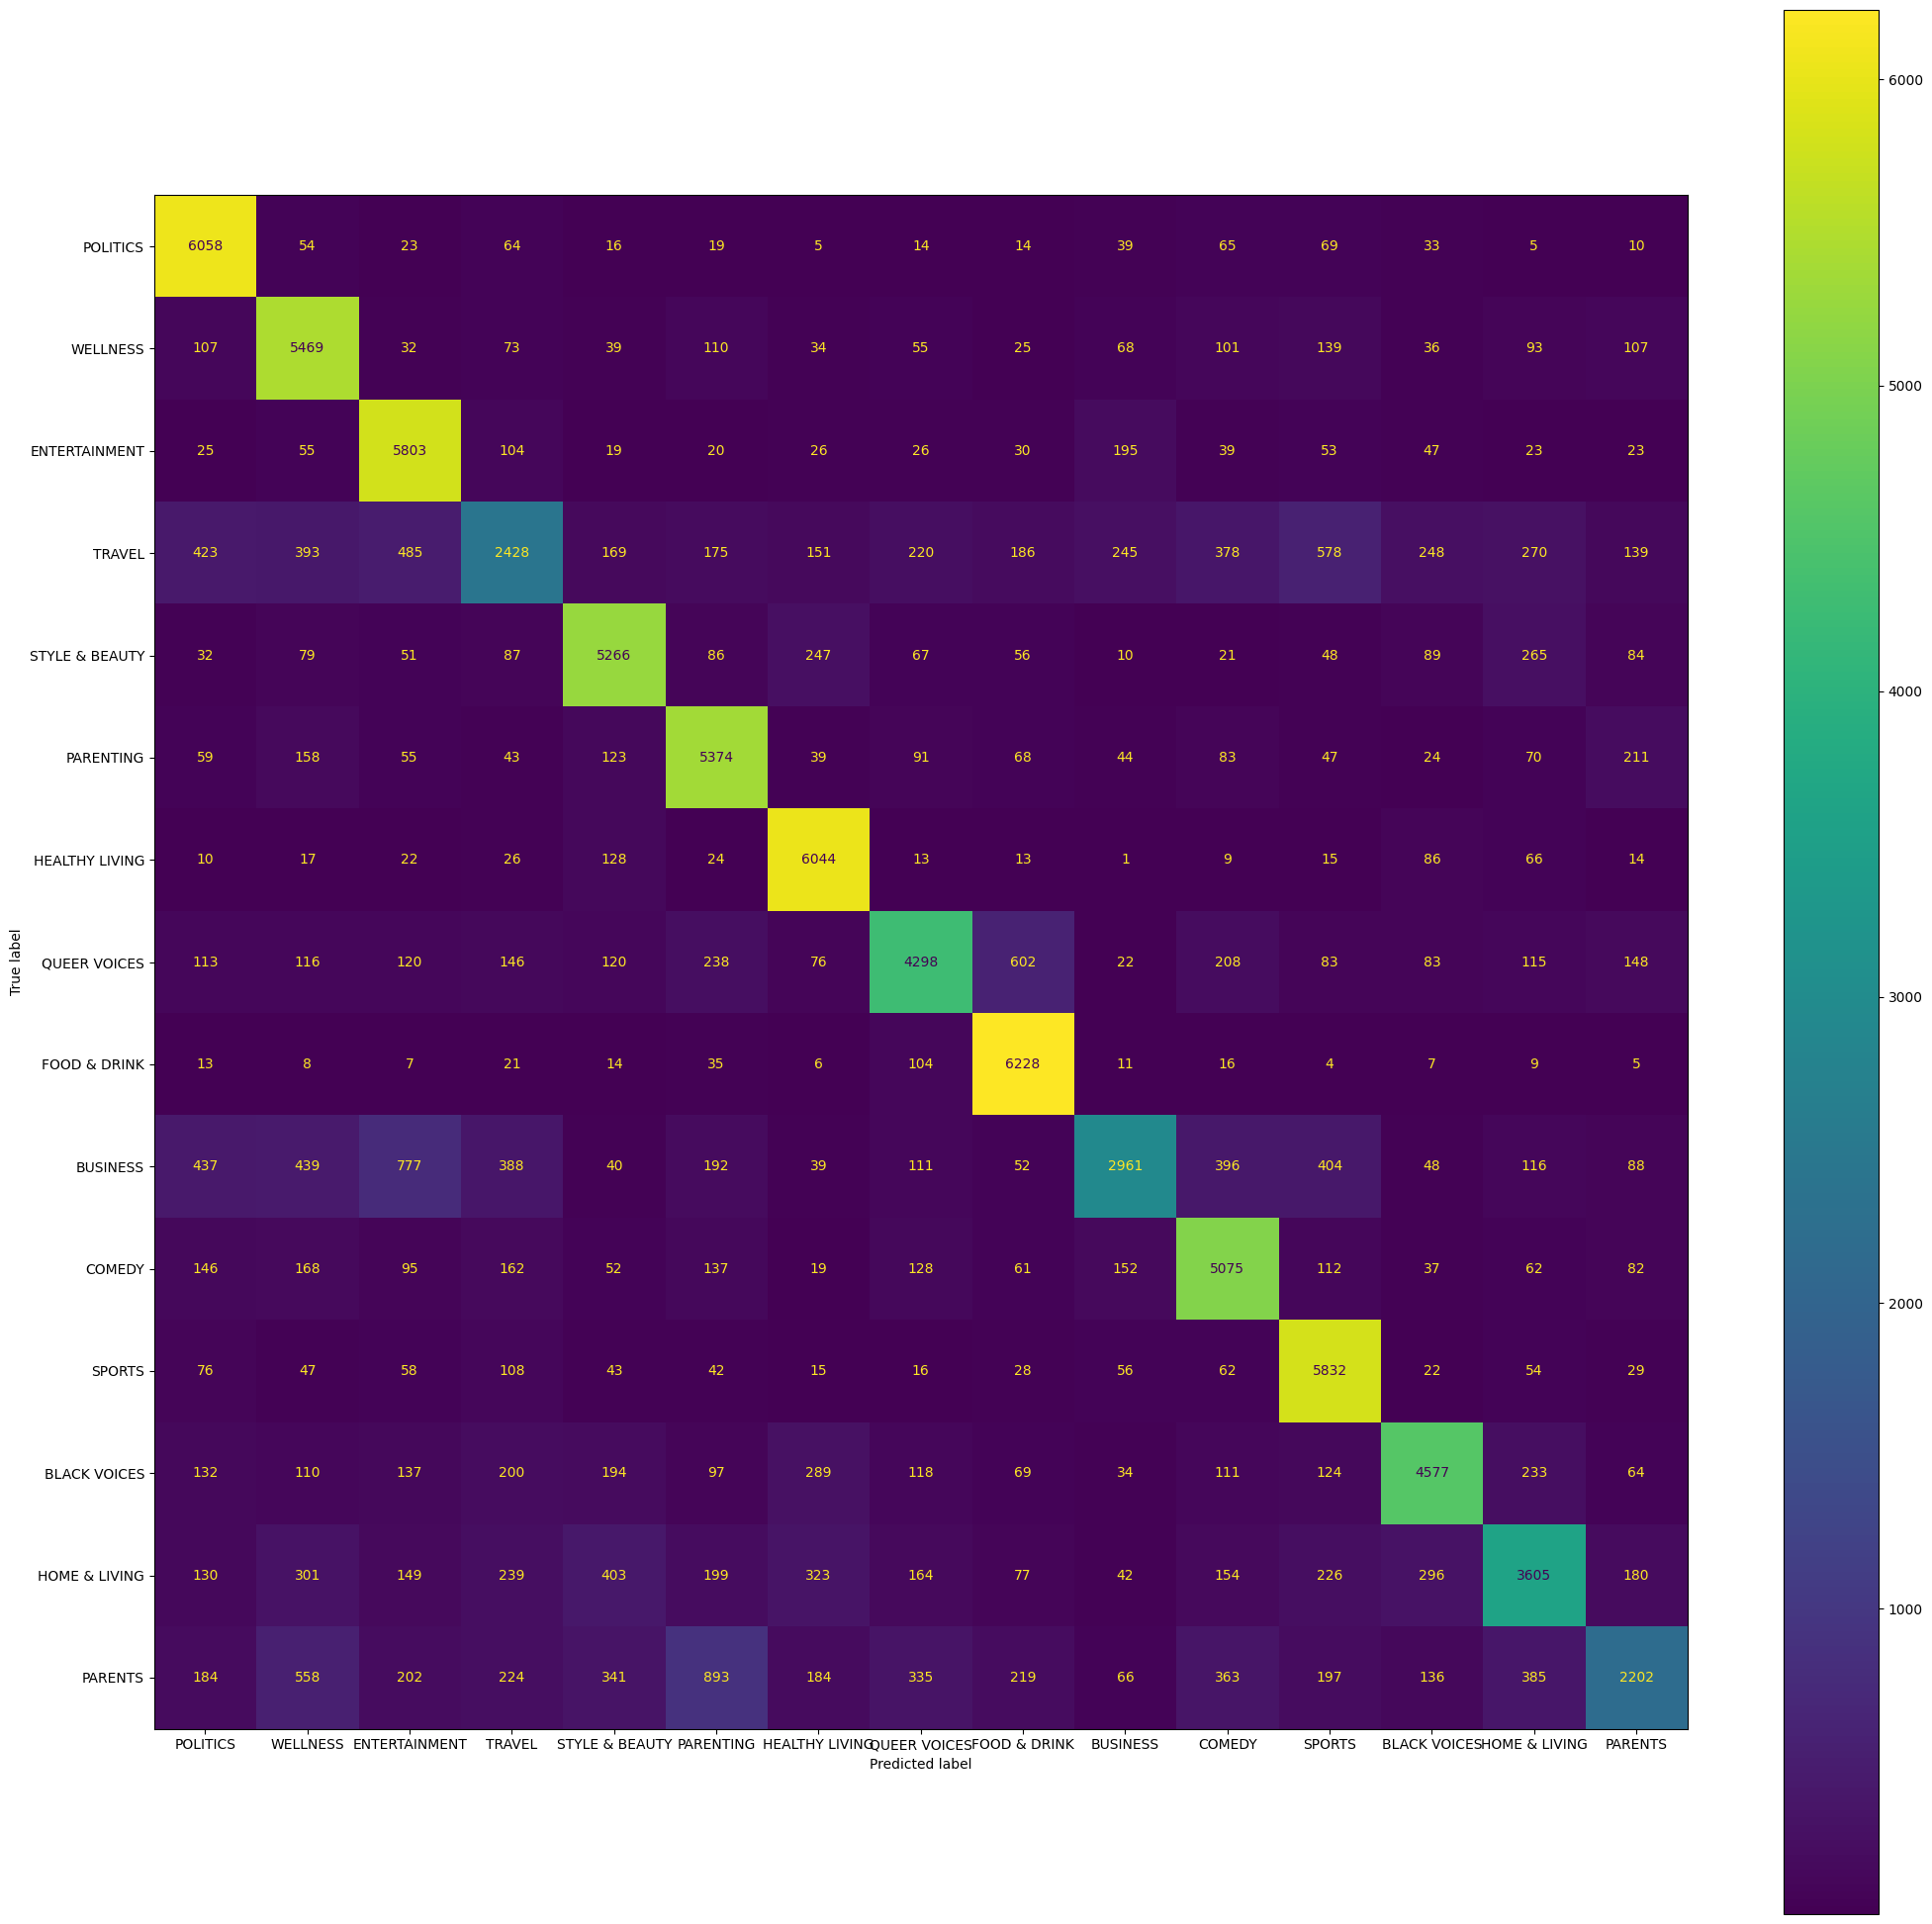

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))
confusion_matrix_knn = metrics.confusion_matrix(y_test_label.tolist(), pred_knn.tolist())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_knn, display_labels = top_categories)
cm_display.plot(ax=ax)
plt.show()